In [152]:
#importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs                          
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [153]:
#load train & test data to data frames
df_train_values=pd.read_csv("Data/train_set_values.csv")
df_train_labels=pd.read_csv("Data/train_set_labels.csv") 
df_test_values=pd.read_csv("data/test_set_values.csv")

In [154]:
df_train_values

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [155]:
df_train_labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [156]:
#check & merging training values & labels
df_train_values.set_index('id',inplace=True)
df_train_labels.set_index('id',inplace=True)

In [157]:
df_train = pd.merge(df_train_labels, df_train_values, how = 'inner', left_index = True,right_index=True)
df_train.reset_index(inplace=True)

In [158]:
df_train

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [159]:
#check for missing values
df_train.isna().sum().sort_values(ascending=False)

scheme_name              28166
scheme_management         3877
installer                 3655
funder                    3635
public_meeting            3334
permit                    3056
subvillage                 371
source                       0
management                   0
waterpoint_type              0
source_class                 0
extraction_type              0
source_type                  0
extraction_type_group        0
extraction_type_class        0
management_group             0
quantity_group               0
payment                      0
payment_type                 0
construction_year            0
water_quality                0
quality_group                0
quantity                     0
id                           0
recorded_by                  0
status_group                 0
population                   0
ward                         0
lga                          0
district_code                0
region_code                  0
region                       0
basin   

In [160]:
#check for balance of the dataset
df_train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [161]:
df_train['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [162]:
df_train['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [163]:
#quantity & quantity group columns have same data, so we can drop one of the

In [164]:
df_train['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [165]:
df_train['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [166]:
##payment and payment_type columns have same data, so we can drop one of them

In [167]:
df_train['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [168]:
df_train['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [169]:
df_train['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [170]:
df_train.groupby(['extraction_type_class','extraction_type_group']).count()

id  status_group  amount_tsh  \
extraction_type_class extraction_type_group                                    
gravity               gravity                26780         26780       26780   
handpump              afridev                 1770          1770        1770   
                      india mark ii           2400          2400        2400   
                      india mark iii            98            98          98   
                      nira/tanira             8154          8154        8154   
                      other handpump           364           364         364   
                      swn 80                  3670          3670        3670   
motorpump             mono                    2865          2865        2865   
                      other motorpump          122           122         122   
other                 other                   6430          6430        6430   
rope pump             rope pump                451           451         451   
submersible           submersible             6179          6179        6179   
wind-powered          wind-powered             117           117         117   

                                             date_recorded  funder  \
extraction_type_class extraction_type_group                          
gravity               gravity                        26780   24704   
handpump              afridev                         1770    1668   
                      india mark ii                   2400    2358   
                      india mark iii                    98      98   
                      nira/tanira                     8154    7899   
                      other handpump                   364     353   
                      swn 80                          3670    3596   
motorpump             mono                            2865    2577   
                      other motorpump                  122     122   
other                 other                           6430    6010   
rope pump             rope pump                        451     448   
submersible           submersible                     6179    5820   
wind-powered          wind-powered                     117     112   

                                             gps_height  installer  longitude  \
extraction_type_class extraction_type_group                                     
gravity               gravity                     26780      24714      26780   
handpump              afridev                      1770       1665       1770   
                      india mark ii                2400       2358       2400   
                      india mark iii                 98         98         98   
                      nira/tanira                  8154       7885       8154   
                      other handpump                364        354        364   
                      swn 80                       3670       3593       3670   
motorpump             mono                         2865       2578       2865   
                      other motorpump               122        122        122   
other                 other                        6430       6002       6430   
rope pump             rope pump                     451        448        451   
submersible           submersible                  6179       5816       6179   
wind-powered          wind-powered                  117        112        117   

                                             latitude  wpt_name  ...  \
extraction_type_class extraction_type_group                      ...   
gravity               gravity                   26780     26780  ...   
handpump              afridev                    1770      1770  ...   
                      india mark ii              2400      2400  ...   
                      india mark iii               98        98  ...   
                      nira/tanira                8154      8154  ...   
                      other handpump              364       364  ...   
    

In [171]:
##extractio_type, extraction_type_group & extraction_type_class columns have same informations, so we can drop two of them

In [172]:
df_train['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [173]:
df_train['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [174]:
#waterpoint_type and waterpoint_type_group columns have same type of informations, but waterpoint_type contains more details, so keep waterpoint_type and drop waterpoint_type_group

In [175]:
df_train['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [176]:
df_train['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [177]:
df_train['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [178]:
df_train.groupby(['source_class','source']).count()

id  status_group  amount_tsh  \
source_class source                                                  
groundwater  hand dtw                874           874         874   
             machine dbh           11075         11075       11075   
             shallow well          16824         16824       16824   
             spring                17021         17021       17021   
surface      dam                     656           656         656   
             lake                    765           765         765   
             rainwater harvesting   2295          2295        2295   
             river                  9612          9612        9612   
unknown      other                   212           212         212   
             unknown                  66            66          66   

                                   date_recorded  funder  gps_height  \
source_class source                                                    
groundwater  hand dtw                        874     868         874   
             machine dbh                   11075   10252       11075   
             shallow well                  16824   16302       16824   
             spring                        17021   15870       17021   
surface      dam                             656     647         656   
             lake                            765     763         765   
             rainwater harvesting           2295    2099        2295   
             river                          9612    8715        9612   
unknown      other                           212     204         212   
             unknown                          66      45          66   

                                   installer  longitude  latitude  wpt_name  \
source_class source                                                           
groundwater  hand dtw                    868        874       874       874   
             machine dbh               10246      11075     11075     11075   
             shallow well              16286      16824     16824     16824   
             spring                    15870      17021     17021     17021   
surface      dam                         646        656       656       656   
             lake                        762        765       765       765   
             rainwater harvesting       2096       2295      2295      2295   
             river                      8721       9612      9612      9612   
unknown      other                       204        212       212       212   
             unknown                      46         66        66        66   

                                   ...  management_group  payment  \
source_class source                ...                              
groundwater  hand dtw              ...               874      874   
             machine dbh           ...             11075    11075   
             shallow well          ...             16824    16824   
             spring                ...             17021    17021   
surface      dam                   ...               656      656   
             lake                  ...               765      765   
             rainwater harvesting  ...              2295     2295   
             river                 ...              9612     9612   
unknown      other                 ...               212      212   
             unknown               ...                66       66   

                                   payment_type  water_quality  quality_group  \
source_class source                                                             
groundwater  hand dtw                       874            874            874   
             machine dbh                  11075          11075          11075   
             shallow well                 16824          16824          16824   
             spring                       17021          17021          17021   
surface      dam                            656            656      

In [179]:
#source, source_type & source_class columns have same type of informations, but source contains more details, so keep source and drop source_type & source_class

In [180]:
#features to drop up to this point
#'quantity_group','source_class','source_type','quality_group','payment_type','extraction_type_class','extraction_type', 'waterpoint_type_group'

In [181]:
df_train.drop(columns=['quantity_group','source_class','source_type','quality_group',
                'payment_type','extraction_type_class','extraction_type', 'waterpoint_type_group'],inplace=True )

In [182]:
df_test_values.drop(columns=['quantity_group','source_class','source_type','quality_group',
                'payment_type','extraction_type_class','extraction_type', 'waterpoint_type_group'],inplace=True )

In [183]:
df_train

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,permit,construction_year,extraction_type_group,management,management_group,payment,water_quality,quantity,source,waterpoint_type
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,False,1999,gravity,vwc,user-group,pay annually,soft,enough,spring,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,True,2010,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,True,2009,gravity,vwc,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,True,1986,submersible,vwc,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,True,0,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,...,True,1999,gravity,water board,user-group,pay per bucket,soft,enough,spring,communal standpipe
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,...,True,1996,gravity,vwc,user-group,pay annually,soft,enough,river,communal standpipe
59397,37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,...,False,0,swn 80,vwc,user-group,pay monthly,fluoride,enough,machine dbh,hand pump
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,...,True,0,nira/tanira,vwc,user-group,never pay,soft,insufficient,shallow well,hand pump


In [184]:
df_test_values

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,permit,construction_year,extraction_type_group,management,management_group,payment,water_quality,quantity,source,waterpoint_type
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,True,2012,other,parastatal,parastatal,never pay,soft,seasonal,rainwater harvesting,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,True,2000,gravity,vwc,user-group,never pay,soft,insufficient,spring,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,NaN,2010,other,vwc,user-group,never pay,soft,insufficient,rainwater harvesting,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,True,1987,other,vwc,user-group,unknown,soft,dry,shallow well,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,True,2000,gravity,water board,user-group,pay monthly,soft,enough,spring,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,True,1988,mono,vwc,user-group,never pay,soft,enough,river,communal standpipe
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,False,1994,nira/tanira,vwc,user-group,pay annually,salty,insufficient,shallow well,hand pump
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,NaN,2010,gravity,vwc,user-group,never pay,soft,insufficient,dam,communal standpipe
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,True,2009,gravity,vwc,user-group,never pay,soft,insufficient,river,communal standpipe


In [185]:
#wpt_name, scheme_name and id columns haven't data about the functionality

In [186]:
df_train.drop(columns=['wpt_name', 'scheme_name', 'id'],inplace=True )

In [187]:
df_test_values.drop(columns=['wpt_name', 'scheme_name'],inplace=True )

In [188]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

In [189]:
df_train['subvillage'].nunique()

19287

In [190]:
#we can drop subvillage because it contains lot of categorical values, so hard to handle

In [192]:
categorical_cols = ['funder', 'installer', 'basin', 'subvillage', 'region',  'public_meeting',
       'lga', 'ward','permit', 'scheme_management', 'extraction_type_group', 'management', 'management_group', 'payment', 'water_quality', 'quantity', 'source','waterpoint_type']

In [193]:
numerical_cols = df_train.select_dtypes('number').columns
numerical_cols

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')

In [194]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

In [195]:
categorical_cols = list(df_train.select_dtypes('object').columns)
categorical_cols

['status_group',
 'date_recorded',
 'funder',
 'installer',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type_group',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

In [196]:
for col in numerical_cols:
    df_train[col].fillna(df[col].mean(), inplace=True)

In [197]:
for col in (categorical_cols):
    df_train[col].fillna(value='Unknown', inplace=True)

In [198]:
#after filling missing values
df_train.isna().sum().sort_values(ascending=False)

status_group             0
amount_tsh               0
source                   0
quantity                 0
water_quality            0
payment                  0
management_group         0
management               0
extraction_type_group    0
construction_year        0
permit                   0
scheme_management        0
recorded_by              0
public_meeting           0
population               0
ward                     0
lga                      0
district_code            0
region_code              0
region                   0
subvillage               0
basin                    0
num_private              0
latitude                 0
longitude                0
installer                0
gps_height               0
funder                   0
date_recorded            0
waterpoint_type          0
dtype: int64

In [199]:
labelencoder = LabelEncoder()
for col in (categorical_cols):
    df_train[col]=labelencoder.fit_transform(df[col])

In [200]:
X_train, X_test = train_test_split(df_train, test_size = 0.2, random_state = 4)

In [201]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880 entries, 16063 to 44850
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           11880 non-null  int32  
 1   amount_tsh             11880 non-null  float64
 2   date_recorded          11880 non-null  int32  
 3   funder                 11880 non-null  int32  
 4   gps_height             11880 non-null  int64  
 5   installer              11880 non-null  int32  
 6   longitude              11880 non-null  float64
 7   latitude               11880 non-null  float64
 8   num_private            11880 non-null  int64  
 9   basin                  11880 non-null  int32  
 10  subvillage             11880 non-null  int32  
 11  region                 11880 non-null  int32  
 12  region_code            11880 non-null  int64  
 13  district_code          11880 non-null  int64  
 14  lga                    11880 non-null  int32  
 15

In [202]:
X = X_train.copy()
y=X.pop('status_group')

In [121]:
sfs1 = SFS(RandomForestClassifier(criterion='gini',   #with sqrrfs 0.6948, with out sqrrfs 68.88
                          min_samples_split=5,
                          min_samples_leaf=1,
                          max_features='auto',
                          oob_score=False,
                          random_state=1,
                           n_jobs=-1
                        
                          ) , 
           k_features=X.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=5)
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  2.9min finished

[2021-09-17 16:54:10] Features: 1/29 -- score: 0.6492003367003367[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  2.5min finished

[2021-09-17 16:56:41] Features: 2/29 -- score: 0.7189183501683502[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.2min finished

[2021-09-17 17:00:54] Features: 3/29 -- score: 0.7528198653198652[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.1s finished

[2021-09-17 18:29:42] Features: 28/29 -- score: 0.8110900673400673[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s finished

[2021-09-17 18:30:04] Features: 29/29 -- score: 0.8100589225589225

In [125]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(26,)","[0.6539351851851852, 0.6495159932659933, 0.646...",0.6492,"(quantity,)",0.00329,0.00256,0.00128
2,"(14, 26)","[0.720223063973064, 0.7163299663299664, 0.7236...",0.718918,"(ward, quantity)",0.004299,0.003345,0.001672
3,"(14, 26, 28)","[0.7566287878787878, 0.7508417508417509, 0.752...",0.75282,"(ward, quantity, waterpoint_type)",0.004366,0.003397,0.001698
4,"(2, 14, 26, 28)","[0.7671506734006734, 0.7679924242424242, 0.768...",0.768392,"(funder, ward, quantity, waterpoint_type)",0.001944,0.001512,0.000756
5,"(2, 13, 14, 26, 28)","[0.7795664983164983, 0.7774621212121212, 0.780...",0.779272,"(funder, lga, ward, quantity, waterpoint_type)",0.003584,0.002788,0.001394
6,"(2, 13, 14, 21, 26, 28)","[0.7847222222222222, 0.7835648148148148, 0.787...",0.785354,"(funder, lga, ward, extraction_type_group, qua...",0.001989,0.001548,0.000774
7,"(1, 2, 13, 14, 21, 26, 28)","[0.7879840067340067, 0.7870370370370371, 0.791...",0.790067,"(date_recorded, funder, lga, ward, extraction_...",0.003763,0.002928,0.001464
8,"(1, 2, 13, 14, 20, 21, 26, 28)","[0.7929292929292929, 0.7939814814814815, 0.795...",0.794949,"(date_recorded, funder, lga, ward, constructio...",0.002696,0.002097,0.001049
9,"(0, 1, 2, 13, 14, 20, 21, 26, 28)","[0.7928240740740741, 0.7954545454545454, 0.797...",0.796528,"(amount_tsh, date_recorded, funder, lga, ward,...",0.003205,0.002494,0.001247
10,"(0, 1, 2, 13, 14, 15, 20, 21, 26, 28)","[0.7956649831649831, 0.7967171717171717, 0.799...",0.799053,"(amount_tsh, date_recorded, funder, lga, ward,...",0.003846,0.002993,0.001496


In [126]:
sfdf1.loc[sfdf1.avg_score==sfdf1.avg_score.max()]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
22,"(0, 1, 2, 3, 5, 6, 7, 9, 12, 13, 14, 15, 17, 1...","[0.8086069023569024, 0.8118686868686869, 0.814...",0.812079,"(amount_tsh, date_recorded, funder, gps_height...",0.003517,0.002736,0.001368


In [128]:
selected_feat1=list(sfdf1.loc[29, 'feature_idx'])
z=X.iloc[:,selected_feat1]

In [129]:
z.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_group', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'waterpoint_type'],
      dtype='object')

In [134]:
features = ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_group', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'waterpoint_type']

In [136]:
X = X_train.copy()[features]
y=X_train.pop('status_group')

Feature ranking:
1. feature 26 (0.127386)
2. feature 5 (0.089176)
3. feature 6 (0.086460)
4. feature 28 (0.070791)
5. feature 9 (0.058457)
6. feature 1 (0.053794)
7. feature 3 (0.047815)
8. feature 20 (0.045323)
9. feature 21 (0.044325)
10. feature 14 (0.040976)
11. feature 2 (0.038258)
12. feature 15 (0.034120)
13. feature 4 (0.031081)
14. feature 0 (0.029318)
15. feature 13 (0.026975)
16. feature 27 (0.024696)
17. feature 24 (0.022823)
18. feature 25 (0.017402)
19. feature 12 (0.016907)
20. feature 10 (0.015333)
21. feature 22 (0.014987)
22. feature 11 (0.014932)
23. feature 18 (0.012963)
24. feature 8 (0.011791)
25. feature 16 (0.008370)
26. feature 19 (0.007646)
27. feature 23 (0.006491)
28. feature 7 (0.001406)
29. feature 17 (0.000000)


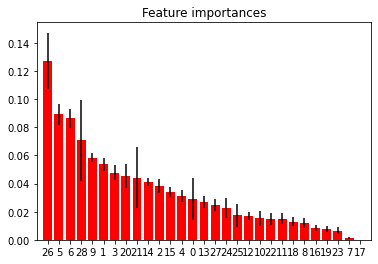

In [144]:
rf=RandomForestClassifier(criterion='gini',   
                          min_samples_split=5,
                          min_samples_leaf=1,
                          max_features='auto',
                          oob_score=False,
                          random_state=1,
                           n_jobs=-1)
rf.fit(X, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [145]:
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 26 (0.127386)
2. feature 5 (0.089176)
3. feature 6 (0.086460)
4. feature 28 (0.070791)
5. feature 9 (0.058457)
6. feature 1 (0.053794)
7. feature 3 (0.047815)
8. feature 20 (0.045323)
9. feature 21 (0.044325)
10. feature 14 (0.040976)
11. feature 2 (0.038258)
12. feature 15 (0.034120)
13. feature 4 (0.031081)
14. feature 0 (0.029318)
15. feature 13 (0.026975)
16. feature 27 (0.024696)
17. feature 24 (0.022823)
18. feature 25 (0.017402)
19. feature 12 (0.016907)
20. feature 10 (0.015333)
21. feature 22 (0.014987)
22. feature 11 (0.014932)
23. feature 18 (0.012963)
24. feature 8 (0.011791)
25. feature 16 (0.008370)
26. feature 19 (0.007646)
27. feature 23 (0.006491)
28. feature 7 (0.001406)
29. feature 17 (0.000000)


In [150]:
for f in range(X.shape[1]):
    print(features[indices[f]])

quantity
longitude
latitude
waterpoint_type
subvillage
date_recorded
gps_height
construction_year
extraction_type_group
ward
funder
population
installer
amount_tsh
lga
source
payment
water_quality
district_code
region
management
region_code
scheme_management
basin
public_meeting
permit
management_group
num_private
recorded_by
